# Модель для определения возрастной категории пользователей

- Автор: Ильин А.В.
- Дата: 04.01.2026

**Содержимое проекта**

1. [Цели и задачи проекта](#section1)
2. [Подготовка среды и библиотек](#section2)
3. [Исследовательский анализ данных](#section3)
4. [Предобработка данных](#section4)
5. [Обучение и оценка базовой модели](#section5)
6. [Создание и отбор признаков](#section6)
7. [Подбор гиперпараметров моделей](#section7)
8. [Подготовка артефактов модели для внедрения](#section8)
9. [Выводы о результатах работы](#section9)

<a class='anchor' id="section1"></a>
## Цели и задачи проекта

Разработать модель для определения возрастной категории пользователей. В качестве основной метрики будем использовать F1.

### Описание данных

Данные состоят из шести датасетов.

- `/datasets/ds_s13_users.csv` — информация о возрастной категории пользователя;
- `/datasets/ds_s13_visits.csv` — информация об активности пользователей разных сайтов;
- `/datasets/ads_activity.csv` — информация об активность взаимодействия пользователя с рекламными объявлениями;
- `/datasets/surf_depth.csv` — информация характеризующая глубину перехода пользователя по сайтам во время одной сессии;
- `/datasets/primary_device.csv` — информация о типе основного устройства пользователя для выхода в Интернет;
- `/datasets/cloud_usage.csv` — информация об использование облачных технологий.

### Описание датасета `ds_s13_users`

- `user_id` — уникальный идентификатор пользователя;
- `age_category` — возрастная категория пользователя.

### Описание датасета `ds_s13_visits`

- `user_id` — уникальный идентификатор пользователя;
- `date` — дата посещения сайта;
- `daytime` — анонимизированное время посещения сайта;
- `session_id` — уникальный идентификатор сессии;
- `website_category` — анонимизированная категория сайта.

### Описание датасета `ads_activity`

- `user_id` — уникальный идентификатор пользователя;
- `ads_activity` — характеристика CTR.

### Описание датасета `surf_depth`

- `user_id` — уникальный идентификатор пользователя;
- `surf_depth` — категориальная переменная, характеризующая глубину перехода пользователя по сайтам во время одной сессии.

### Описание датасета `primary_device`

- `user_id` — уникальный идентификатор пользователя;
- `primary_device` — информация о типе основного устройства пользователя для выхода в Интернет.

### Описание датасета `cloud_usage`

- `user_id` — уникальный идентификатор пользователя;
- `cloud_usage` — `True` означает, что пользователь обращается к облачным ресурсам.

## Подготовка среды и библиотек

Установим необходимые библиотеки.

In [1]:
!pip install -q phik
!pip install -q scikit-learn==1.6.1
!pip install -q joblib 

Импортируем библиотеки

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    make_scorer,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)
from sklearn.model_selection import (
    cross_validate,
    cross_val_score,
    GridSearchCV,
    train_test_split,
    StratifiedKFold
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    StandardScaler,
    TargetEncoder    
)
from sklearn.svm import SVC

from phik import phik_matrix

import joblib

from IPython.display import display

Сделаем необходимые настройки отображения

In [3]:
# Отображать все столбцы
pd.set_option('display.max_columns', None)

# Устанавливаем опцию для отображения всех содержимого в ячейках
pd.set_option('display.max_colwidth', None)

pd.set_option('display.float_format', '{:.6f}'.format)

Пропишем константы

In [4]:
RANDOM_STATE = 42

Выгрузим данные в переменные.

In [5]:
ds_s13_users_df = pd.read_csv('https://code.s3.yandex.net/datasets/ds_s13_users.csv')
ds_s13_visits_df = pd.read_csv('https://code.s3.yandex.net/datasets/ds_s13_visits.csv')
ads_activity_df = pd.read_csv('https://code.s3.yandex.net/datasets/ads_activity.csv')
surf_depth_df = pd.read_csv('https://code.s3.yandex.net/datasets/surf_depth.csv')
primary_device_df = pd.read_csv('https://code.s3.yandex.net/datasets/primary_device.csv')
cloud_usage_df = pd.read_csv('https://code.s3.yandex.net/datasets/cloud_usage.csv')

In [6]:
df_data = {
    'ds_s13_users_df': ds_s13_users_df,
    'ds_s13_visits_df': ds_s13_visits_df,
    'ads_activity_df': ads_activity_df,
    'surf_depth_df': surf_depth_df,
    'primary_device_df': primary_device_df,
    'cloud_usage_df': cloud_usage_df,
}

Посмотрим на данные датафреймов.

In [7]:
for name, data in df_data.items():
    print(f'Данные датафрейма {name}')
    print(data.info())
    display(data.head())
    print(50 * '-')
    print()

Данные датафрейма ds_s13_users_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       5913 non-null   object
 1   age_category  5913 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 92.5+ KB
None


,user_id,age_category
0,f545-8c95aefe8d3e5548a689-a5b2fd39,4
1,cb48-5a0d6cde4d86ae10637e-c8ceb6ed,2
2,678b-614cd47d854b9d591db2-000b2e50,0
3,4ac0-dad169100b4a29b20818-b26ae7c5,4
4,f19b-9ac21ca973b41ecfa8c3-6a58191d,0


--------------------------------------------------

Данные датафрейма ds_s13_visits_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065745 entries, 0 to 1065744
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   date              1065745 non-null  object
 1   daytime           1065745 non-null  object
 2   session_id        1065745 non-null  object
 3   user_id           1065745 non-null  object
 4   website_category  1065745 non-null  object
dtypes: object(5)
memory usage: 40.7+ MB
None


,date,daytime,session_id,user_id,website_category
0,2025-11-01,вечер,066e4e02-8c1f-45eb-a50f-178659abe698,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 17
1,2025-11-01,вечер,0bce1749-3376-439c-9a22-f8ffbba00e9a,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 19
2,2025-11-01,вечер,3445d8c4-221d-4d88-bb6a-a2939fe3c610,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 18
3,2025-11-01,вечер,3bf97286-1d91-4aaa-af4a-ed58eceb8cd2,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 20
4,2025-11-01,вечер,40e22712-3cad-410d-a9f0-13bd8f6911c0,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 05


--------------------------------------------------

Данные датафрейма ads_activity_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826 entries, 0 to 5825
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       5826 non-null   object
 1   ads_activity  5826 non-null   object
dtypes: object(2)
memory usage: 91.2+ KB
None


,user_id,ads_activity
0,e318-d8e69c86b543a5fb927c-c36fb6e6,очень часто
1,35cd-a972339dec534f49332c-a8b6d383,редко
2,f7e6-3b29cf9cb7ed4bb00d8f-81534360,очень редко
3,5186-e25a37549e50f45b2b43-178eaabe,умеренно
4,febd-077f277466253ee04ef6-42656680,умеренно


--------------------------------------------------

Данные датафрейма surf_depth_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5715 entries, 0 to 5714
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     5715 non-null   object
 1   surf_depth  5715 non-null   object
dtypes: object(2)
memory usage: 89.4+ KB
None


,user_id,surf_depth
0,f238-0c4c1e787cce311541b7-736925a0,поверхностно
1,9030-1b562ad80182b6dc27f1-ce811740,глубоко
2,22e0-7c6cadcc45e246b8688d-c43c9b23,поверхностно
3,9d7f-a19f10756378940a49b5-5d03e1ef,поверхностно
4,4233-bb5ae4b09827e5497094-1a4956af,глубоко


--------------------------------------------------

Данные датафрейма primary_device_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5669 entries, 0 to 5668
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         5669 non-null   object
 1   primary_device  5669 non-null   object
dtypes: object(2)
memory usage: 88.7+ KB
None


,user_id,primary_device
0,d602-ec060db7597a6b8cd4e7-aa625896,смартфон
1,9204-9558455be649d4e77945-b5e25d62,ПК
2,5eea-22babd6a9474b43b9d0b-a39a4cf2,ноутбук
3,c142-0296948e8d08e417de10-2da9523c,смартфон
4,abec-bb4092da51eb2233a928-e44ba074,ПК


--------------------------------------------------

Данные датафрейма cloud_usage_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5680 entries, 0 to 5679
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      5680 non-null   object
 1   cloud_usage  5680 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 50.0+ KB
None


,user_id,cloud_usage
0,a1e4-91c8a52eb855595e653f-298ce305,False
1,db9a-7b8e9e94448b7fcb19b6-4edca15f,False
2,0d55-9ad768879e9b08ca7ff9-843f76c7,True
3,4baa-43285d10a6d3cc969f2a-b21881d1,False
4,b8cd-cbb2411db005115ca64d-32700c62,False


--------------------------------------------------



На основе предварительного анализа данных можно сказать, что пропуски отсутствуют во всех датафреймах. Типы данных корректные. Названия столбцов не требуют корректировки.

## Исследовательский анализ данных

### Анализ дубликатов

Проверим данные на наличие дубликатов.

In [8]:
for name, data in df_data.items():
    print(f'Количество дубликатов в датафрейме {name}: {data.duplicated().sum()}')

Количество дубликатов в датафрейме ds_s13_users_df: 87
Количество дубликатов в датафрейме ds_s13_visits_df: 15750
Количество дубликатов в датафрейме ads_activity_df: 233
Количество дубликатов в датафрейме surf_depth_df: 0
Количество дубликатов в датафрейме primary_device_df: 0
Количество дубликатов в датафрейме cloud_usage_df: 0


В датафремах `ds_s13_users_df`, `ds_s13_visits_df` и `ads_activity_df` были найдены дубликаты, удалим их.

In [9]:
for name, data in df_data.items():
    df_data[name] = data.drop_duplicates()
    print(f'Количество дубликатов в датафрейме {name}: {df_data[name].duplicated().sum()}')

Количество дубликатов в датафрейме ds_s13_users_df: 0
Количество дубликатов в датафрейме ds_s13_visits_df: 0
Количество дубликатов в датафрейме ads_activity_df: 0
Количество дубликатов в датафрейме surf_depth_df: 0
Количество дубликатов в датафрейме primary_device_df: 0
Количество дубликатов в датафрейме cloud_usage_df: 0


Проверим на уникальность значения в столбце `user_id` в каждом датафрейме.

In [10]:
for name, data in df_data.items():
    print(f'Количество дубликатов в столбце user_id в датафрейме {name}: {data["user_id"].duplicated().sum()}')

Количество дубликатов в столбце user_id в датафрейме ds_s13_users_df: 0
Количество дубликатов в столбце user_id в датафрейме ds_s13_visits_df: 1044169
Количество дубликатов в столбце user_id в датафрейме ads_activity_df: 0
Количество дубликатов в столбце user_id в датафрейме surf_depth_df: 0
Количество дубликатов в столбце user_id в датафрейме primary_device_df: 0
Количество дубликатов в столбце user_id в датафрейме cloud_usage_df: 0


В датафрейме `ds_s13_visits_df` остались дубли `user_id`, так как у одного пользователя могло быть несколько сессий.

### Подготовка данных и создание общего датафрейма

Сгруппируем данные в датафрейме `ds_s13_visits_df` по `user_id`, оставив столбцы `daytime` и `website_category` в которых выберем самое часто встречающееся значение для конкретного пользователя. Также добавим два столбцы с количеством уникальных дней и количеством сессий у каждого пользователя.

In [11]:
df_data['ds_s13_visits_df'] = df_data['ds_s13_visits_df'].groupby('user_id').agg({
    'daytime': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'website_category': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'date': ['nunique', 'count']
}).reset_index()
df_data['ds_s13_visits_df'].columns = ['user_id', 'daytime', 'website_category', 'unique_days', 'total_sessions']

In [12]:
df_data['ds_s13_visits_df']

,user_id,daytime,website_category,unique_days,total_sessions
0,0010-5cf8f6b38a7b6c70a021-009dbcda,вечер,Category 19,14,546
1,0013-4ae5f7d127b91a3fb0f8-ba59f141,день,Category 08,14,185
2,0014-d3032d60979a8d2b3077-f09bdce8,день,Category 13,14,117
3,001a-eee53e44f848608779b0-78704a67,вечер,Category 14,14,287
4,002c-40a064b12e1217e12207-a56eaf3b,день,Category 13,14,490
...,...,...,...,...,...
5821,ff8f-8167e729650d17c3add4-205d9000,вечер,Category 06,14,118
5822,ff92-8c8d93a642a46d347963-033140eb,вечер,Category 15,14,346
5823,ffa9-44aaa5379e9d408ff0dc-0f7f6119,вечер,Category 12,14,100
5824,ffab-d0fa7686828005ebbcd1-a4b28b3a,день,Category 08,14,168


In [13]:
df_data['ds_s13_visits_df']['avg_sessions_per_day'] = round(
    (df_data['ds_s13_visits_df']['total_sessions'] / df_data['ds_s13_visits_df']['unique_days']), 3
)

In [14]:
df_data['ds_s13_visits_df'].head()

,user_id,daytime,website_category,unique_days,total_sessions,avg_sessions_per_day
0,0010-5cf8f6b38a7b6c70a021-009dbcda,вечер,Category 19,14,546,39.000000
1,0013-4ae5f7d127b91a3fb0f8-ba59f141,день,Category 08,14,185,13.214000
2,0014-d3032d60979a8d2b3077-f09bdce8,день,Category 13,14,117,8.357000
3,001a-eee53e44f848608779b0-78704a67,вечер,Category 14,14,287,20.500000
4,002c-40a064b12e1217e12207-a56eaf3b,день,Category 13,14,490,35.000000


Столбцы `total_sessions` и `unique_days` больше не нужны, их можно удалить.

In [15]:
df_data['ds_s13_visits_df'] = df_data['ds_s13_visits_df'].drop(columns=['total_sessions', 'unique_days'])

Объединим данные в единый датафрейм по полю `user_id`, а затем удалим этот столбец, так как это техническая информация.

In [16]:
df = df_data['ds_s13_users_df']
for name, data in list(df_data.items()):
    if name != 'ds_s13_users_df':
        df = pd.merge(df, data, on='user_id', how='left')

In [17]:
df = df.drop(columns=['user_id'])

In [18]:
df.head()

,age_category,daytime,website_category,avg_sessions_per_day,ads_activity,surf_depth,primary_device,cloud_usage
0,4,день,Category 05,13.357000,NaN,глубоко,смартфон,False
1,2,вечер,Category 07,10.071000,умеренно,средне,смартфон,False
2,0,вечер,Category 12,7.143000,умеренно,средне,смартфон,False
3,4,день,Category 18,17.714000,редко,поверхностно,смартфон,True
4,0,вечер,Category 12,8.500000,очень редко,поверхностно,смартфон,True


### Анализ признаков

In [19]:
cat_features = df.select_dtypes(include=['object']).columns
num_features = df.select_dtypes(include=['int', 'float']).columns

# Удаляем age_Category из числовых признаков
num_features = num_features.drop(['age_category'], errors='ignore').tolist()

Проверим количество уникальных значений у категориальных признаков.

In [20]:
for column in cat_features:
    print(f"Уникальные значения в столбце {column}:", df[column].unique())

Уникальные значения в столбце daytime: ['день' 'вечер' 'утро']
Уникальные значения в столбце website_category: ['Category 05' 'Category 07' 'Category 12' 'Category 18' 'Category 14'
 'Category 08' 'Category 17' 'Category 13' 'Category 06' 'Category 16'
 'Category 04' 'Category 19' 'Category 03' 'Category 15' 'Category 01'
 'Category 10' 'Category 02' 'Category 09' 'Category 20' 'Category 11']
Уникальные значения в столбце ads_activity: [nan 'умеренно' 'редко' 'очень редко' 'очень часто' 'часто']
Уникальные значения в столбце surf_depth: ['глубоко' 'средне' 'поверхностно' nan]
Уникальные значения в столбце primary_device: ['смартфон' 'ноутбук' 'ПК' 'планшет' nan]
Уникальные значения в столбце cloud_usage: [False True nan]


Столбец `website_category` имеет больше 10 значений, поэтому при предобработке для него будем использовать TargetEncoding кодирование, для остальных столбцов OneHotEncoding кодирование.

Посмотрим на распределение целевой переменной.

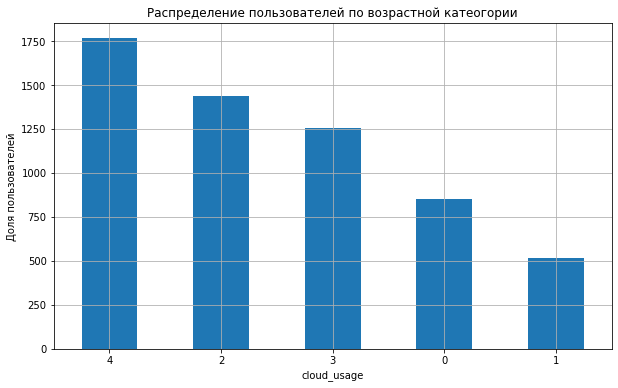

In [21]:
df['age_category'].value_counts().plot(
    kind='bar',
    rot=0,
    title=f'Распределение пользователей по возрастной катеогории',
    figsize=(10, 6)
)

plt.xlabel(column)
plt.ylabel('Доля пользователей')
plt.grid()
plt.show()

В распределении целевой переменной присутствует дисбаланс. Для усреднения метрик будем использовать macro усреднение.

Посмотрим на распределение категориальных признаков в разрезе возрастной категории.

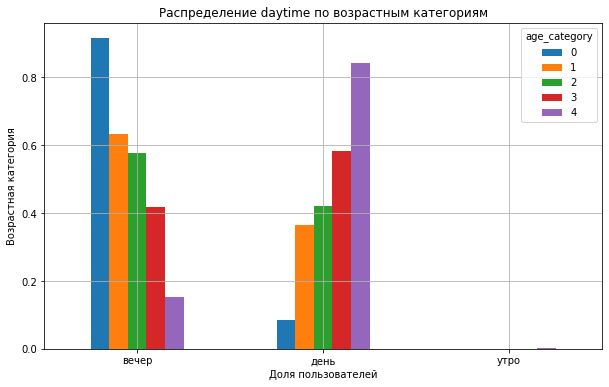

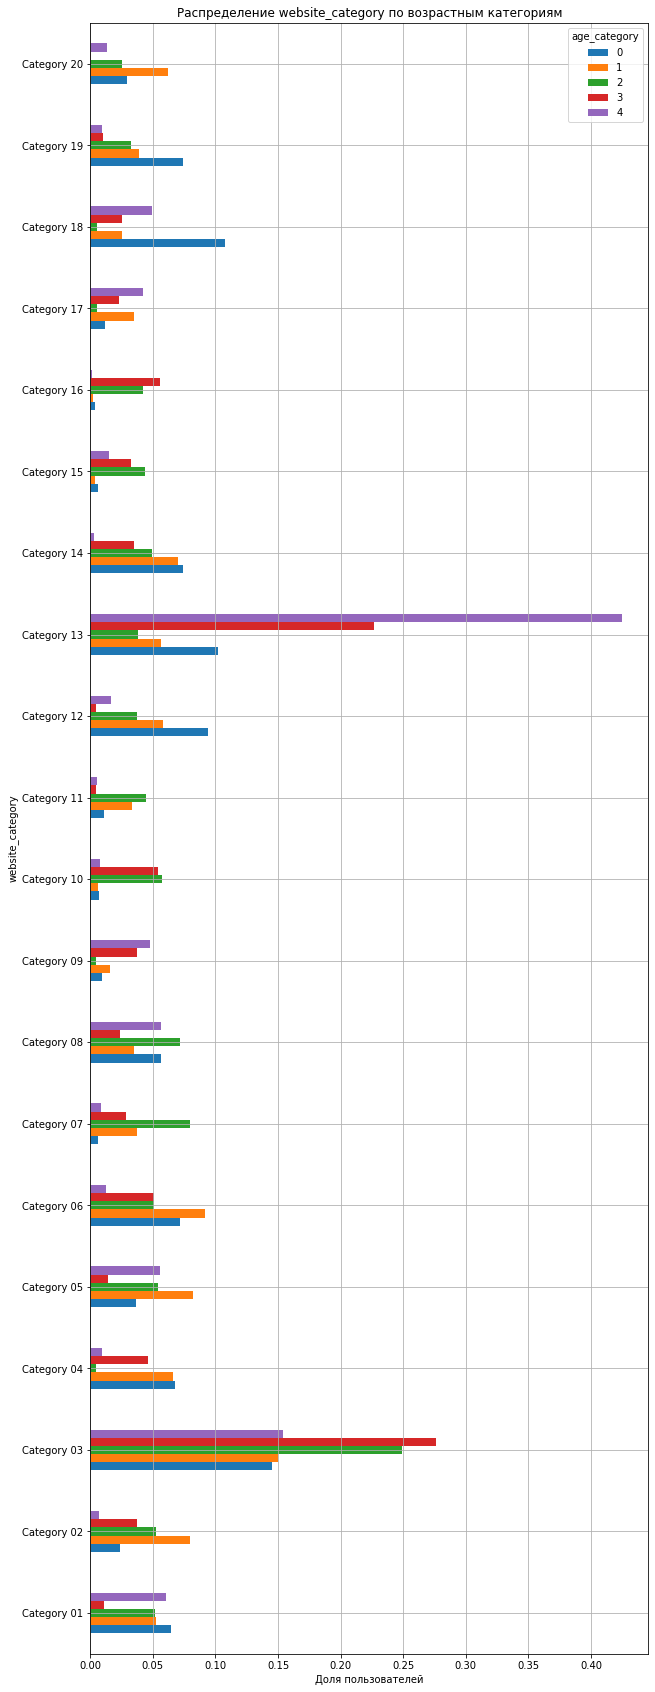

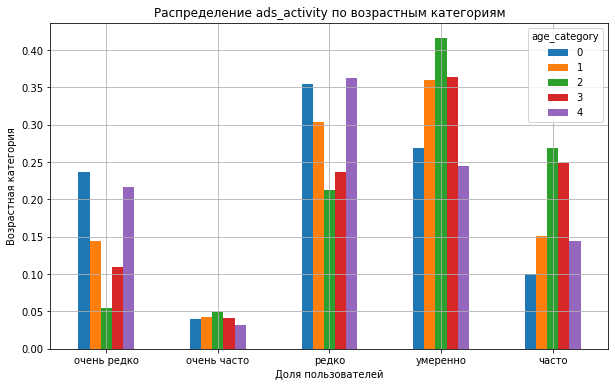

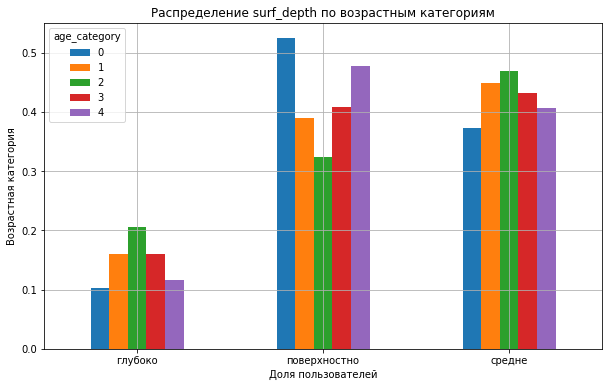

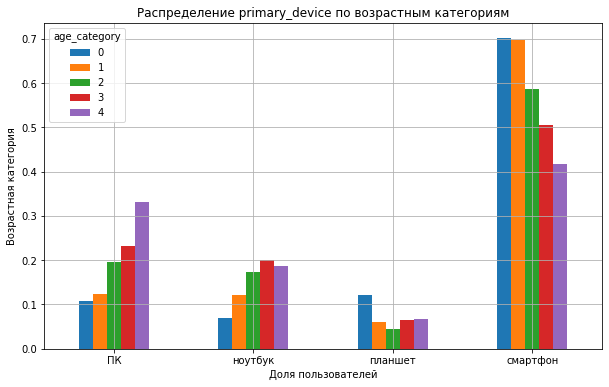

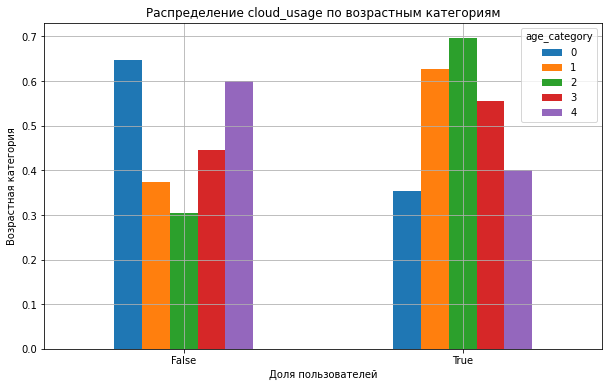

In [22]:
for column in cat_features:
    grouped = df.groupby('age_category')[column].value_counts(normalize=True).unstack(fill_value=0)
    grouped = grouped.T
    
    grouped.plot(
        kind=('barh' if column == 'website_category' else 'bar'),
        rot=0,
        title=f'Распределение {column} по возрастным категориям',
        figsize=((10, 30) if column == 'website_category' else (10, 6))
    )
    
    plt.xlabel('Доля пользователей')
    plt.ylabel(column if column == 'website_category' else 'Возрастная категория')
    plt.grid()
    plt.show()

Проанализируем числовые признаки.

In [23]:
def show_features_distribution (df, columns):
    for column in columns:
        print(f'Статистические данные параметра {column}')
        print()
        print(df[column].describe(percentiles=[0.25, 0.5, 0.75, 0.99]))
        print('')
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        df.boxplot(column=column, vert=False, ax=axs[0])
        axs[0].set_title(f'Распределение параметра {column}')
        axs[0].set_xlabel('Размер, мм')

        sns.histplot(df[column], kde=True, bins=37, color='skyblue', edgecolor='black')
        axs[1].set_title(f'Распределение параметра {column}')
        axs[1].set_xlabel(column)
        axs[1].set_ylabel('Количество')
        axs[1].grid()

        plt.show()

        print('')

Статистические данные параметра avg_sessions_per_day

count   5826.000000
mean      12.874052
std        5.369729
min        7.143000
25%        8.857000
50%       11.929000
75%       15.214000
99%       31.339500
max       59.929000
Name: avg_sessions_per_day, dtype: float64



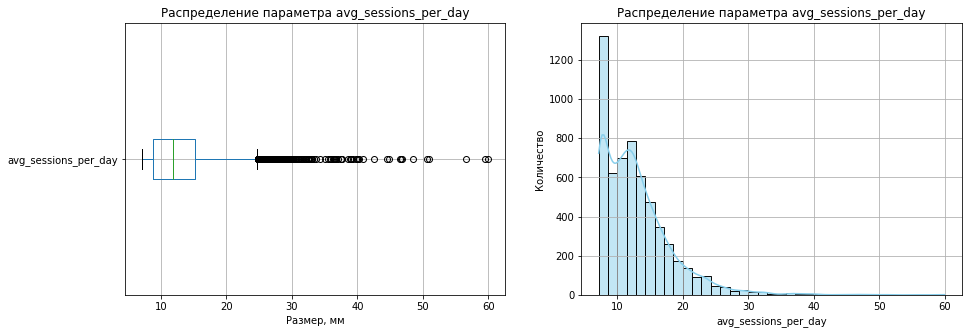

In [24]:
show_features_distribution(df, num_features)

Рапределение по признаку `avg_sessions_per_day` имеет правостороннюю скошенность, имеется всплеск в районе значений 12-13. Присутствуют выбросы справа.

Исходня из визуального анализа распределения можно уже сделать некоторые выводы:

- Пользователи до 18 пользуются интернетом в основном вечером, пользователи старше 56 лет днем.
- Пользователи старше 40 лет чаще заходят на сайты категории `Category 03` и `Category 13`. Пользователи в возрасте от 26 до 40 лет на сайты в категории `Category 13`.
- Большая часть пользователей младше 18 и старше 56 лет редко взаиодействуют с рекламой, в остальных возрастных категориях преобладают пользователи с умеренным взаимодействием с рекламой.
- Большая часть пользователей младше 18 и старше 56 лет имеют низкую глубину просмотра сайтов, у остальных категорий в основном средняя глубина просмотра.
- У всех возрастных категорий преобладающим устройством является смартфон.
- Большая часть пользователей младше 18 и старше 56 лет не пользуются облачными сервисами, у остальных категорий наоборот.

### Корреляция между признаками

Построим матрицу корреялии между признаками.

In [25]:
corr_columns = np.concatenate((cat_features, ['age_category']))

In [26]:
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix = df[corr_columns].phik_matrix()
correlation_matrix

interval columns not set, guessing: ['age_category']


,daytime,website_category,ads_activity,surf_depth,primary_device,cloud_usage,age_category
daytime,1.000000,0.279980,0.032571,0.000000,0.096570,0.014511,0.430829
website_category,0.279980,1.000000,0.133726,0.107273,0.147046,0.154113,0.626992
ads_activity,0.032571,0.133726,1.000000,0.019941,0.000000,0.070508,0.367874
surf_depth,0.000000,0.107273,0.019941,1.000000,0.000000,0.018896,0.140736
primary_device,0.096570,0.147046,0.000000,0.000000,1.000000,0.000000,0.183185
cloud_usage,0.014511,0.154113,0.070508,0.018896,0.000000,1.000000,0.214420
age_category,0.430829,0.626992,0.367874,0.140736,0.183185,0.214420,1.000000


Визуализируем корреляцию с помощью тепловой карты.

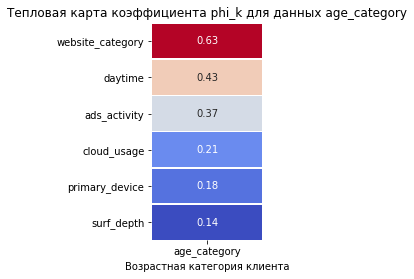

In [27]:
plt.figure(figsize=(2, 4))
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'age_category'][['age_category']].sort_values(by='age_category', ascending=False)
sns.heatmap(data_heatmap,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5,
    cbar=False
)
plt.title('Тепловая карта коэффициента phi_k для данных age_category')
plt.xlabel('Возрастная категория клиента')
plt.show()

Признаки `website_category`, `daytime` и `ads_activity` имею умеренную связь с целевой переменной. Наибольшая связь у `website_category` - 0.62. Признаки `cloud_usage`, `primary_device` и `surf_depth` имеют слабую связь с целевой переменной.

## Предобработка данных

Разделим данные на три части: для обучения (train), валидации (valid) и тестовую (test) в соотношении 60:20:20.

In [28]:
X = df.drop(columns = ['age_category'])
y = df['age_category']

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_valid
)

Проверим пропорции.

In [29]:
print("Размер выборки для обучения:", X_train.shape)
print("Размер выборки для валидации:", X_valid.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер выборки для обучения: (3495, 7)
Размер выборки для валидации: (1165, 7)
Размер тестовой выборки: (1166, 7)


In [30]:
target_cat_features = ['website_category']
onehot_cat_features = cat_features.drop(target_cat_features, errors='ignore').tolist()

onehot_cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

target_cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder()),
])

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
])

cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [31]:
def build_preprocessor(onehot_cat_features, target_cat_features, num_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot_cat', onehot_cat_pipeline, onehot_cat_features),
            ('target_cat', target_cat_pipeline, target_cat_features),
            ('num', num_pipeline, num_features)
        ]
    )
    return preprocessor

In [32]:
# Создаем ColumnTransformer
preprocessor = build_preprocessor(onehot_cat_features, target_cat_features, num_features)

# Предварительный fit() для получения имён признаков
X_valid_processed = preprocessor.fit_transform(X_valid, y_valid)
feature_names = preprocessor.get_feature_names_out()

In [33]:
class SafeFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Безопасный селектор признаков, который проверяет границы массивов.
    Работает даже если количество признаков отличается в разных фолдах.
    """
    def __init__(self, selected_indices):
        self.selected_indices = selected_indices
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Проверяем, какие индексы существуют в текущем X
        valid_indices = [i for i in self.selected_indices if i < X.shape[1]]
        
        if len(valid_indices) > 0:
            return X[:, valid_indices]
        else:
            # Если ни один индекс не валиден, возвращаем нулевую матрицу
            return np.zeros((X.shape[0], 1))

In [34]:
def select_features(X_transformed, indices):
    return X_transformed[:, indices]

In [35]:
def build_pipeline(X, preprocessor, model, selected_features, scoring=None):
    feature_names_all = list(preprocessor.get_feature_names_out())
    selected_indices = [feature_names_all.index(f) for f in selected_features]

    selector = FunctionTransformer(
        select_features, 
        validate=False,
        kw_args={'indices': selected_indices}
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('model', model)
    ])
    
    if scoring is None:
        scoring = {
            'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
            'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
            'recall_macro': make_scorer(recall_score, average='macro', zero_division=0)
        }

    cv_results = cross_validate(
        pipeline,
        X=X,
        y=y_valid, 
        scoring=scoring, 
        cv=cv_splitter, 
        n_jobs=-1,
        return_estimator=True
    )
    return pipeline, cv_results

## Обучение и оценка базовой модели

Обучим базовую модель DummyClassifier.

In [36]:
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_valid)

In [37]:
print(f"F1: {f1_score(y_valid, y_pred_dummy, average='macro'):.4f}")
print(f"Precision: {precision_score(y_valid, y_pred_dummy, average='macro', zero_division=0):.4f}")
print(f"Recall: {recall_score(y_valid, y_pred_dummy, average='macro'):.4f}")

F1: 0.0930
Precision: 0.0606
Recall: 0.2000


Обучим базовую модель LogisticRegression.

In [38]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver="lbfgs", penalty="l2", random_state=RANDOM_STATE)
lr_pipeline, lr_cv_results = build_pipeline(X_valid, preprocessor, lr, feature_names)

Посмотрим на метрики модели LogisticRegression.

In [39]:
print(f"F1: {lr_cv_results['test_f1_macro'].mean():.4f}")
print(f"Precision: {lr_cv_results['test_precision_macro'].mean():.4f}")
print(f"Recall: {lr_cv_results['test_recall_macro'].mean():.4f}")

F1: 0.4363
Precision: 0.4385
Recall: 0.4505


Обучим базовые модели SVC на разных ядрах.

In [40]:
svc_linear = SVC(
    class_weight='balanced',
    kernel='linear',
    random_state=RANDOM_STATE,
)

svc_poly = SVC(
    class_weight='balanced',
    kernel='poly',
    degree=3,
    coef0=1,
    random_state=RANDOM_STATE,
)

svc_rbf = SVC(
    class_weight='balanced',
    kernel='rbf',
    gamma='scale',
    random_state=RANDOM_STATE
)

svc_sigmoid = SVC(
    class_weight='balanced',
    kernel='sigmoid',
    coef0=1,
    gamma='scale',
    random_state=RANDOM_STATE
)

svc_scores = {}

_, svc_scores['linear'] = build_pipeline(X_valid, preprocessor, svc_linear, feature_names)
_, svc_scores['poly'] = build_pipeline(X_valid, preprocessor, svc_poly, feature_names)
_, svc_scores['rbf'] = build_pipeline(X_valid, preprocessor, svc_rbf, feature_names)
_, svc_scores['sigmoid'] = build_pipeline(X_valid, preprocessor, svc_sigmoid, feature_names)

Посмотрим на метрики SVC моделей.

In [41]:
for name, metrics in svc_scores.items():
    print(f"Ядро: {name}")
    print("Средние значения метрик:")
    print(f"F1: {metrics['test_f1_macro'].mean():.4f}")
    print(f"Precision: {metrics['test_precision_macro'].mean():.4f}")
    print(f"Recall: {metrics['test_recall_macro'].mean():.4f}")
    print("-" * 50)

Ядро: linear
Средние значения метрик:
F1: 0.4284
Precision: 0.4354
Recall: 0.4478
--------------------------------------------------
Ядро: poly
Средние значения метрик:
F1: 0.4181
Precision: 0.4217
Recall: 0.4311
--------------------------------------------------
Ядро: rbf
Средние значения метрик:
F1: 0.4173
Precision: 0.4207
Recall: 0.4362
--------------------------------------------------
Ядро: sigmoid
Средние значения метрик:
F1: 0.3074
Precision: 0.3468
Recall: 0.3230
--------------------------------------------------


Среди базовых моделей SVC модель с `linear` ядром показывает лучшие результаты, близкие к результатам модели LogisticRegression, но в целом результаты низкие.

## Создание и отбор признаков

Напишем функцию для создания новых признаков. Возмем корень из признака `avg_sessions_per_day`, чтобы сжать большие значения в нем. Создадим признаки отражающие взаимодействие времени суток и активности и взаимодействие времени суток и категории сайта.

In [42]:
def create_enhanced_features(X):
    """
    Создаёт расширенный набор признаков
    """

    # Создаём копию датасета, чтобы не изменять исходный датасет
    X_enhanced = X.copy()

    # 1. Берем корень из avg_sessions_per_day
    X_enhanced['sqrt_avg_sessions'] = np.sqrt(X_enhanced['avg_sessions_per_day'])
    
    # 2. Взаимодействие времени суток и типа устройства
    X_enhanced["daytime_device"] = (X_enhanced["daytime"] + '_' + X_enhanced["primary_device"])
    
    # 3. # Мобильные облачные пользователи
    X_enhanced['mobile_cloud_user'] = ((X_enhanced['primary_device'] == 'смартфон') & 
                               (X_enhanced['cloud_usage'] == True)).astype(int)
    
    # 4. Активные пользователи рекламы
    active_ads = ['умеренно', 'часто', 'очень часто']
    X_enhanced['is_active_ads_user'] = X_enhanced['ads_activity'].isin(active_ads).astype(int)
    
    # 5. Категория сайта + активность рекламы (предварительно заполняем пропуски)
    X_enhanced['ads_activity_filled'] = X_enhanced['ads_activity'].fillna('неизвестно')
    X_enhanced['website_ads_interaction'] = X_enhanced['website_category'] + '_' + X_enhanced['ads_activity_filled']

    # Удаляем исходные признаки, которые заменили производными
    columns_to_drop = [
        "avg_sessions_per_day",
        "ads_activity_filled"
    ]

    # Удаляем указанные колонки
    X_enhanced = X_enhanced.drop(columns=columns_to_drop)

    return X_enhanced

# Создаем расширенный набор признаков
X_train_enhanced = create_enhanced_features(X_train)
X_valid_enhanced = create_enhanced_features(X_valid)

Проверим распределение признака `sqrt_avg_sessions`.

Статистические данные параметра sqrt_avg_sessions

count   1165.000000
mean       3.569827
std        0.730414
min        2.672639
25%        3.035457
50%        3.464102
75%        3.927977
99%        5.973240
max        7.741382
Name: sqrt_avg_sessions, dtype: float64



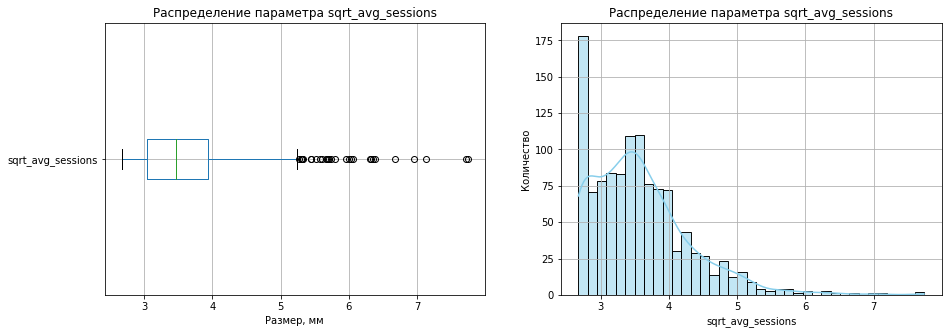

In [43]:
show_features_distribution(X_valid_enhanced, ['sqrt_avg_sessions'])

Распределение стало более равномерным по сравнению с исходным признаком.

In [44]:
X_valid_enhanced.head()

,daytime,website_category,ads_activity,surf_depth,primary_device,cloud_usage,sqrt_avg_sessions,daytime_device,mobile_cloud_user,is_active_ads_user,website_ads_interaction
2219,вечер,Category 02,умеренно,поверхностно,ноутбук,False,3.070668,вечер_ноутбук,0,1,Category 02_умеренно
4871,вечер,Category 04,редко,поверхностно,планшет,True,3.412184,вечер_планшет,0,0,Category 04_редко
5585,вечер,Category 06,часто,поверхностно,смартфон,True,4.062019,вечер_смартфон,1,1,Category 06_часто
327,вечер,Category 13,очень редко,поверхностно,ПК,False,2.738613,вечер_ПК,0,0,Category 13_очень редко
262,вечер,Category 10,умеренно,средне,смартфон,True,3.359464,вечер_смартфон,1,1,Category 10_умеренно


Применим методы-обёртки для отбора признаков.

In [45]:
cat_features_enhanced = X_valid_enhanced.select_dtypes(include=['object']).columns
target_cat_features_enhanced = target_cat_features + ['website_ads_interaction']
onehot_cat_features_enhanced = cat_features_enhanced.drop(target_cat_features_enhanced, errors='ignore').tolist()

num_features_enhanced = X_valid_enhanced.select_dtypes(include=['int', 'float']).columns
num_features_enhanced = num_features_enhanced.drop(['age_category'], errors='ignore').tolist()

# Создаем ColumnTransformer
preprocessor_enhanced = build_preprocessor(onehot_cat_features_enhanced, target_cat_features_enhanced, num_features_enhanced)

X_valid_enhanced_processed = preprocessor_enhanced.fit_transform(X_valid_enhanced, y_valid)
feature_names_enhanced = preprocessor_enhanced.get_feature_names_out()

In [46]:
# Инициализируем модель, которая будет использоваться для оценки важности признаков
lr_estimator = LogisticRegression(max_iter=1000, solver="lbfgs", penalty="l2", random_state=RANDOM_STATE)

# Создаём объект RFE
rfe_selector = RFE(lr_estimator, n_features_to_select=30)

# Обучаем RFE
rfe_selector.fit(X_valid_enhanced_processed, y_valid)

# Получаем информацию о выбранных признаках
rfe_selected_idx = rfe_selector.support_
selected_rfe_features = np.array(feature_names_enhanced)[rfe_selected_idx]

In [47]:
print('Выбранные признаки:')
selected_rfe_features.tolist()

Выбранные признаки:


['onehot_cat__daytime_вечер',
 'onehot_cat__daytime_день',
 'onehot_cat__daytime_утро',
 'onehot_cat__ads_activity_очень редко',
 'onehot_cat__ads_activity_умеренно',
 'onehot_cat__ads_activity_часто',
 'onehot_cat__surf_depth_глубоко',
 'onehot_cat__surf_depth_поверхностно',
 'onehot_cat__primary_device_ПК',
 'onehot_cat__primary_device_ноутбук',
 'onehot_cat__primary_device_планшет',
 'onehot_cat__cloud_usage_False',
 'onehot_cat__cloud_usage_True',
 'onehot_cat__daytime_device_вечер_ноутбук',
 'onehot_cat__daytime_device_вечер_планшет',
 'onehot_cat__daytime_device_вечер_смартфон',
 'onehot_cat__daytime_device_день_ПК',
 'onehot_cat__daytime_device_день_ноутбук',
 'onehot_cat__daytime_device_день_планшет',
 'onehot_cat__daytime_device_день_смартфон',
 'onehot_cat__daytime_device_утро_смартфон',
 'target_cat__website_category_0',
 'target_cat__website_category_1',
 'target_cat__website_category_2',
 'target_cat__website_category_3',
 'target_cat__website_category_4',
 'target_cat__we

In [48]:
lr_pipeline_enhanced, lr_cv_results_enhanced = build_pipeline(X_valid_enhanced, preprocessor_enhanced, lr, selected_rfe_features)

Посмотрим на метрики модели LogisticRegression с добавленными признаками.

In [49]:
print(f"F1: {lr_cv_results_enhanced['test_f1_macro'].mean():.4f}")
print(f"Precision: {lr_cv_results_enhanced['test_precision_macro'].mean():.4f}")
print(f"Recall: {lr_cv_results_enhanced['test_recall_macro'].mean():.4f}")
print()
print(f"Изменение метрики F1: {(lr_cv_results_enhanced['test_f1_macro'].mean() - lr_cv_results['test_f1_macro'].mean()):.4f}")
print(f"Изменение метрики Precision: {(lr_cv_results_enhanced['test_precision_macro'].mean() - lr_cv_results['test_precision_macro'].mean()):.4f}")
print(f"Изменение метрики Recall: {(lr_cv_results_enhanced['test_recall_macro'].mean() - lr_cv_results['test_recall_macro'].mean()):.4f}")

F1: 0.4384
Precision: 0.4440
Recall: 0.4519

Изменение метрики F1: 0.0021
Изменение метрики Precision: 0.0055
Изменение метрики Recall: 0.0014


После добавления новых признаков и отбора метрики улучшились но незначительно.

## Подбор гиперпараметров моделей

Создадим сетку гиперпараметров для модели LogisticRegression и SVC моделей с учётом специфики ядер.

In [50]:
lr_param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__max_iter': [500, 1000, 5000],
    'model__tol': [1e-4, 1e-3, 1e-2]
}

svc_param_grid = [
    {
        "model__kernel": ["linear"],
        "model__C": [0.01, 0.1, 1],
        "model__class_weight": ['balanced']
    },
    {
        "model__kernel": ["poly"],
        "model__C": [0.01, 0.1, 1],
        "model__gamma": ["scale", "auto"],
        "model__degree": [2, 3, 4],
        "model__coef0": [0.0, 1.0],
        "model__class_weight": ['balanced']
    },
    {
        "model__kernel": ["rbf"],
        "model__C": [0.01, 0.1, 1],
        "model__gamma": ["scale", "auto"],
        "model__class_weight": ['balanced']
    },
    {
        "model__kernel": ["sigmoid"],
        "model__C": [0.01, 0.1, 1],
        "model__gamma": ["scale", "auto"],
        "model__coef0": [0.0, 1.0],
        "model__class_weight": ['balanced']
    }
]

Сделаем поиск лучших гиперпараметров.

In [51]:
lr_grid = GridSearchCV(
    estimator=lr_pipeline_enhanced,
    param_grid=lr_param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

svc = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svc_pipeline, svc_cv_results = build_pipeline(X_valid_enhanced, preprocessor_enhanced, svc, selected_rfe_features)
svc_grid = GridSearchCV(
    estimator=svc_pipeline,
    param_grid=svc_param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

Определим лучшие гиперпараметры.

In [52]:
lr_grid.fit(X_valid_enhanced, y_valid)

lr_best_params = lr_grid.best_params_
lr_best_params_clean = {k.replace('model__', ''): v 
                     for k, v in lr_best_params.items()}
lr_best_score = round(lr_grid.best_score_, 3)


svc_grid.fit(X_valid_enhanced, y_valid)

svc_best_params = svc_grid.best_params_
svc_best_params_clean = {k.replace('model__', ''): v 
                     for k, v in svc_best_params.items()}
svc_best_score = round(svc_grid.best_score_, 3)

print()
print("Лучшие гиперпараметры для LogisticRegression:", lr_best_params)
print("Лучший средний результат F1 на кросс-валидации для LogisticRegression:", lr_best_score)
print()
print("Лучшие гиперпараметры для SVC:", svc_best_params)
print("Лучший средний результат F1 на кросс-валидации для SVC:", svc_best_score)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Fitting 3 folds for each of 57 candidates, totalling 171 fits

Лучшие гиперпараметры для LogisticRegression: {'model__C': 100, 'model__max_iter': 500, 'model__tol': 0.0001}
Лучший средний результат F1 на кросс-валидации для LogisticRegression: 0.456

Лучшие гиперпараметры для SVC: {'model__C': 1, 'model__class_weight': 'balanced', 'model__coef0': 1.0, 'model__degree': 2, 'model__gamma': 'scale', 'model__kernel': 'poly'}
Лучший средний результат F1 на кросс-валидации для SVC: 0.425


Выведем топ-15 лучших гиперпараметров.

In [53]:
lr_results = pd.DataFrame(lr_grid.cv_results_)
svc_results = pd.DataFrame(svc_grid.cv_results_)

lr_results['source'] = 'lr'
svc_results['source'] = 'svc'

combined_results = pd.concat([lr_results, svc_results], ignore_index=True)

top_15 = combined_results.sort_values('mean_test_score', ascending=False).head(15)
top_15[['params', 'mean_test_score']]

,params,mean_test_score
45,"{'model__C': 100, 'model__max_iter': 500, 'model__tol': 0.0001}",0.456258
43,"{'model__C': 10, 'model__max_iter': 5000, 'model__tol': 0.001}",0.452581
39,"{'model__C': 10, 'model__max_iter': 1000, 'model__tol': 0.0001}",0.446611
42,"{'model__C': 10, 'model__max_iter': 5000, 'model__tol': 0.0001}",0.443472
48,"{'model__C': 100, 'model__max_iter': 1000, 'model__tol': 0.0001}",0.442401
49,"{'model__C': 100, 'model__max_iter': 1000, 'model__tol': 0.001}",0.440423
28,"{'model__C': 1, 'model__max_iter': 500, 'model__tol': 0.001}",0.440368
46,"{'model__C': 100, 'model__max_iter': 500, 'model__tol': 0.001}",0.439348
33,"{'model__C': 1, 'model__max_iter': 5000, 'model__tol': 0.0001}",0.438616
34,"{'model__C': 1, 'model__max_iter': 5000, 'model__tol': 0.001}",0.437127


## Подготовка артефактов модели для внедрения

In [54]:
final_model = LogisticRegression(solver="lbfgs", penalty="l2", random_state=RANDOM_STATE, **lr_best_params_clean)

final_pipeline, final_cv_results = build_pipeline(X_valid_enhanced, preprocessor_enhanced, final_model, selected_rfe_features)
final_pipeline.fit(X_train_enhanced, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['daytime', 'ads_activity',
                                                   'surf_depth',
                                                   'primary_device',
                                                   'cloud_usage',
                                                   'daytime_device']),
                                                 ('target_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strateg...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sqrt_avg_sessions',
                                                   'mobile_cloud_user',
                                                   'is_active_ads_user'])])),
                ('selector',
                 FunctionTransformer(func=<function select_features at 0x7f8d0aa9d9d0>,
                                     kw_args={'indices': [0, 1, 2, 3, 6, 7, 8,
                                                          9, 11, 12, 13, 15, 16,
                                                          18, 19, 20, 21, 22,
                                                          23, 24, 25, 26, 27,
                                                          28, 29, 30, 31, 32,
                                                          33, 35]})),
                ('model',
                 LogisticRegression(C=100, max_iter=500, random_state=42))])

In [55]:
X_test_enhanced = create_enhanced_features(X_test)

y_pred = final_pipeline.predict(X_test_enhanced)
print("F1:", round(f1_score(y_test, y_pred, average="macro"), 2))
print(classification_report(y_test, y_pred))

F1: 0.45
              precision    recall  f1-score   support

           0       0.54      0.63      0.58       171
           1       0.28      0.05      0.08       103
           2       0.48      0.57      0.52       288
           3       0.42      0.29      0.34       251
           4       0.66      0.81      0.73       353

    accuracy                           0.54      1166
   macro avg       0.48      0.47      0.45      1166
weighted avg       0.51      0.54      0.52      1166



F1 = 0.45 - низкий средний результат.

Сохраним итоговую модель и пайплайн предобработки в файл final_model.joblib.

In [56]:
joblib.dump(final_pipeline, 'final_model.joblib')

['final_model.joblib']

Протестируем сохраненную модель. Загрузим файл и проверим загруженную модель на тестовых данных.

In [57]:
# Загрузим модель из файла 'final_model.joblib' в переменную loaded_model
loaded_model = joblib.load('final_model.joblib')

# Получаем предсказание
prediction = loaded_model.predict(X_test_enhanced)
prediction_proba = loaded_model.predict_proba(X_test_enhanced)

print(prediction)
prediction_proba

[4 3 4 ... 4 3 2]


array([[0.00431433, 0.00546185, 0.0152017 , 0.14241058, 0.83261153],
       [0.00442613, 0.01836456, 0.17476832, 0.41179818, 0.3906428 ],
       [0.00951   , 0.01018374, 0.00879046, 0.11133764, 0.86017815],
       ...,
       [0.0042498 , 0.0067942 , 0.0143962 , 0.13026046, 0.84429934],
       [0.02345469, 0.10642044, 0.30721441, 0.39140257, 0.17150789],
       [0.13525807, 0.29315973, 0.45582989, 0.07916363, 0.03658868]])

## Выводы о результатах работы

Модель демонстрирует среднее общее качество (F1=0.45), но с сильной вариацией по классам. Хорошо распознается класс 4 (F1=0.74), удовлетворительно — классы 0 и 2 (F1=0.57 и 0.52), плохо — класс 3 (F1=0.35) и критически плохо — класс 1 (F1=0.07).
Основная проблема — дисбаланс классов и недостаточное качество для классов с малым количеством примеров. Модель нуждается в доработке, особенно для малых классов. Требуется балансировка данных.

### Рекомендации

- балансировка классов;
- улучшение признакового пространства;
- увеличение выборки для малых классов;

Cсылка на репоизиторий https://github.com/alexilin83/ds_sprint_13